In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Get the data ready

In [3]:
ride_data = pd.read_csv('fremont.csv', index_col='Date', parse_dates=True)
weather_data = pd.read_csv('seattle_weather_new.csv', index_col='DATE', parse_dates=True)

In [4]:
weather_data.columns

Index(['STATION', 'NAME', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN',
       'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT08', 'WT09', 'WT13', 'WT14',
       'WT16', 'WT18', 'WT22'],
      dtype='object')

In [5]:
ride_data.head()
ride_data['Total'] = ride_data['Fremont Bridge East Sidewalk'] + ride_data['Fremont Bridge West Sidewalk']

In [6]:
daily = pd.DataFrame(columns=['Total'])
daily['Total'] = ride_data.resample('D').sum()['Total']

daily['PRCP'] = weather_data['PRCP']
daily['SNOW'] = weather_data['SNOW']
daily['SNWD'] = weather_data['SNWD']
daily['AWND'] = weather_data['AWND']
daily['TAVG'] = (weather_data['TMAX'] + weather_data['TMIN'])/2

In [7]:
daily.head()

,Total,PRCP,SNOW,SNWD,AWND,TAVG
Date,,,,,,
2012-10-03,3521.0,0.0,0.0,0.0,16.33,56.0
2012-10-04,3475.0,0.0,0.0,0.0,14.54,56.5
2012-10-05,3148.0,0.0,0.0,0.0,12.75,59.5
2012-10-06,2006.0,0.0,0.0,0.0,11.41,60.5
2012-10-07,2142.0,0.0,0.0,0.0,2.91,60.5


In [8]:
daily.shape

(2401, 6)

In [9]:
daily.tail()

,Total,PRCP,SNOW,SNWD,AWND,TAVG
Date,,,,,,
2019-04-26,3839.0,0.00,0.0,0.0,8.72,54.0
2019-04-27,1519.0,0.14,0.0,0.0,8.05,48.0
2019-04-28,2249.0,0.00,0.0,0.0,8.28,48.5
2019-04-29,4516.0,0.00,0.0,0.0,9.62,54.5
2019-04-30,4928.0,0.00,0.0,0.0,6.04,54.0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


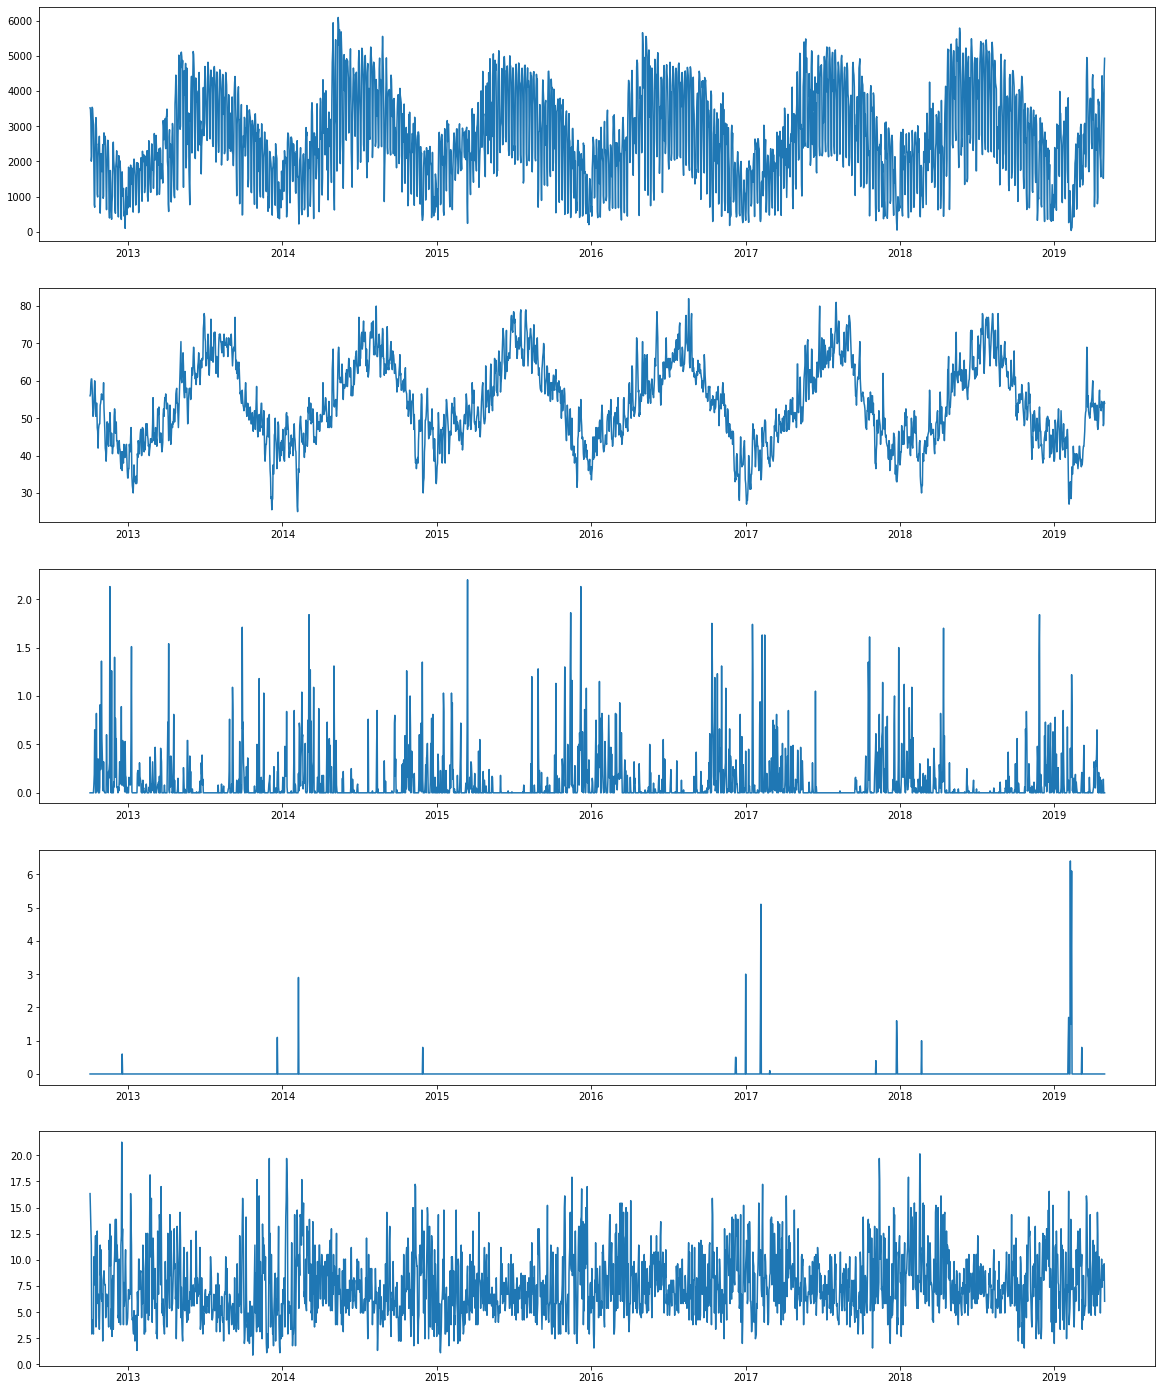

In [10]:
fig, ax = plt.subplots(5,1, figsize=(20,25))

ax[0].plot(daily.index, daily['Total'])
ax[1].plot(daily.index, daily['TAVG'])
ax[2].plot(daily.index, daily['PRCP'])
ax[3].plot(daily.index, daily['SNOW'])
ax[4].plot(daily.index, daily['AWND'])

# Get fbprophet

In [11]:
import fbprophet
fbprophet.__version__

'0.5'

In [12]:
Prophet = fbprophet.Prophet

In [13]:
data_train = daily.loc[:str(2018-1),:]

In [14]:
data_train.shape

(1916, 6)

In [15]:
data_test = daily.loc[str(2018),:]

In [16]:
data_test.shape

(365, 6)

In [17]:
data_train.head()

,Total,PRCP,SNOW,SNWD,AWND,TAVG
Date,,,,,,
2012-10-03,3521.0,0.0,0.0,0.0,16.33,56.0
2012-10-04,3475.0,0.0,0.0,0.0,14.54,56.5
2012-10-05,3148.0,0.0,0.0,0.0,12.75,59.5
2012-10-06,2006.0,0.0,0.0,0.0,11.41,60.5
2012-10-07,2142.0,0.0,0.0,0.0,2.91,60.5


In [18]:
data_train.reset_index(inplace=True)
data_test.reset_index(inplace=True)
    
data_train = data_train.rename({'Date':'ds', 'Total':'y'}, axis=1)
data_test = data_test.rename({'Date':'ds', 'Total':'y'}, axis=1)

In [19]:
data_train.tail()

,ds,y,PRCP,SNOW,SNWD,AWND,TAVG
1911,2017-12-27,997.0,0.00,0.0,1.2,3.80,37.0
1912,2017-12-28,972.0,0.34,0.0,0.0,10.74,43.0
1913,2017-12-29,591.0,1.50,0.0,0.0,10.29,46.5
1914,2017-12-30,725.0,0.11,0.0,0.0,11.63,43.0
1915,2017-12-31,734.0,0.00,0.0,0.0,12.30,38.0


In [20]:
data_test.head()

,ds,y,PRCP,SNOW,SNWD,AWND,TAVG
0,2018-01-01,674.0,0.00,0.0,0.0,8.72,37.5
1,2018-01-02,2498.0,0.00,0.0,0.0,7.83,39.0
2,2018-01-03,2827.0,0.00,0.0,0.0,8.72,41.0
3,2018-01-04,2578.0,0.13,0.0,0.0,2.68,41.0
4,2018-01-05,1866.0,0.51,0.0,0.0,6.49,48.0


In [21]:
Prophet = fbprophet.Prophet

m = Prophet(mcmc_samples=300, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)
m.add_country_holidays(country_name='US')

In [22]:
m.fit(data_train)

# Make future dataframe for prediction

In [23]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')
future.head()


,ds
0,2012-10-03
1,2012-10-04
2,2012-10-05
3,2012-10-06
4,2012-10-07


In [24]:
future.tail()

,ds
2276,2018-12-27
2277,2018-12-28
2278,2018-12-29
2279,2018-12-30
2280,2018-12-31


In [25]:
future.shape

(2281, 1)

In [26]:
# here is the forecast
forecast = m.predict(future)

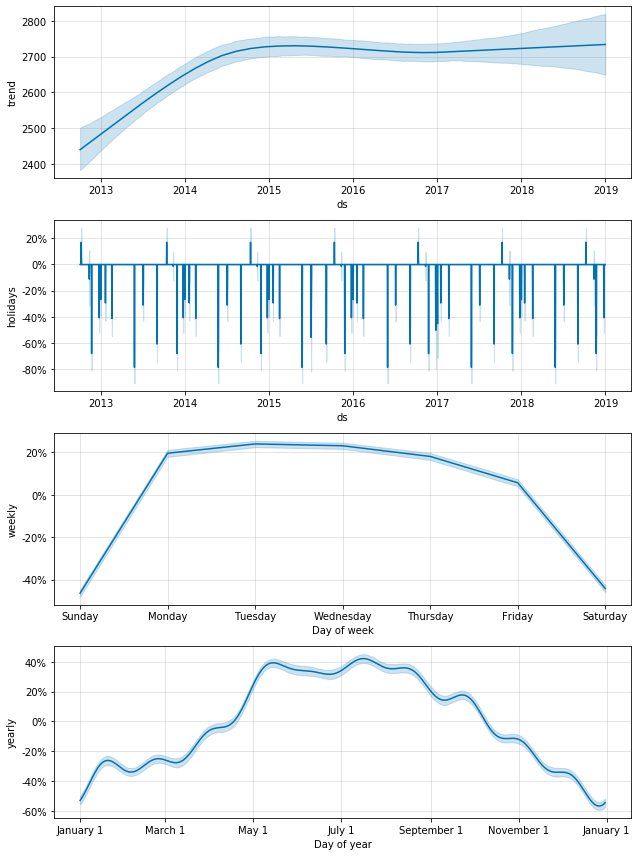

In [27]:
f = m.plot_components(forecast)

In [28]:
def make_verif(forecast, data_train, data_test): 
    """
    Put together the forecast (coming from fbprophet) 
    and the overved data, and set the index to be a proper datetime index, 
    for plotting
    Parameters
    ----------
    forecast : pandas.DataFrame 
        The pandas.DataFrame coming from the `forecast` method of a fbprophet 
        model. 
    
    data_train : pandas.DataFrame
        The training set, pandas.DataFrame
    data_test : pandas.DataFrame
        The training set, pandas.DataFrame
    
    Returns
    -------
    forecast : 
        The forecast DataFrane including the original observed data.
    """
    
    forecast.index = pd.to_datetime(forecast.ds)
    data_train.index = pd.to_datetime(data_train.ds) 
    data_test.index = pd.to_datetime(data_test.ds)
    data = pd.concat([data_train, data_test], axis=0)
    forecast.loc[:,'y'] = data.loc[:,'y']
    
    return forecast

def plot_verif(verif, year=2017):
    """
    plots the forecasts and observed data, the `year` argument is used to visualise 
    the division between the training and test sets. 
    Parameters
    ----------
    verif : pandas.DataFrame
        The `verif` DataFrame coming from the `make_verif` function in this package
    year : integer
        The year used to separate the training and test set. Default 2017
    Returns
    -------
    f : matplotlib Figure object
    """
    
    f, ax = plt.subplots(figsize=(20, 10)) 
    train = verif.loc[:str(year - 1),:]
    ax.plot(train.index, train.y, 'ko', markersize=3)
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    test = verif.loc[str(year):,:]
    ax.plot(test.index, test.y, 'ro', markersize=3)
    ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
#     ax.axvline(year, color='0.8', alpha=0.7)
    ax.grid(ls=':', lw=0.5)
    
    return f


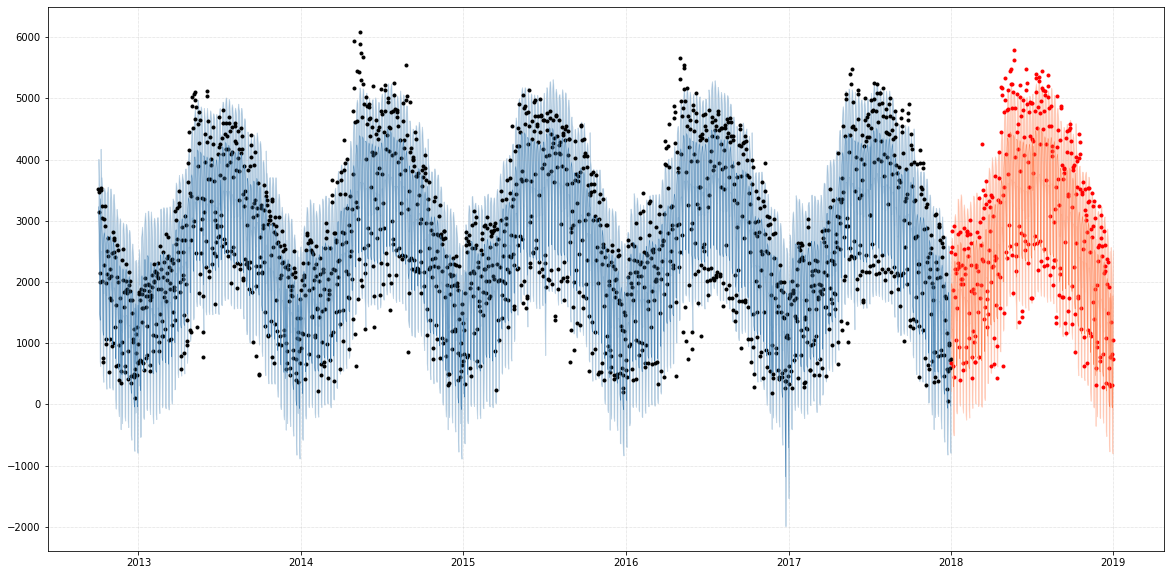

In [29]:
verif = make_verif(forecast, data_train, data_test)
f = plot_verif(verif, year=2018);


In [30]:
from sklearn.utils import check_array
def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Use of this metric is not recommended; for illustration only. 
    See other regression metrics on sklearn docs:
      http://scikit-learn.org/stable/modules/classes.html#regression-metrics
    Use like any other metric
    >>> y_true = [3, -0.5, 2, 7]; y_pred = [2.5, -0.3, 2, 8]
    >>> mean_absolute_percentage_error(y_true, y_pred)
    Out[]: 24.791666666666668
    """

    y_true, y_pred = check_array(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [31]:
from sklearn.metrics import mean_absolute_error as MAE

from scipy.stats import skew

MAE(verif.loc['2018':,'y'].values, verif.loc['2018':,'yhat'].values)

524.6190443702754

In [33]:
residuals = (verif.loc['2018':,'yhat'] - verif.loc['2018':,'y'])

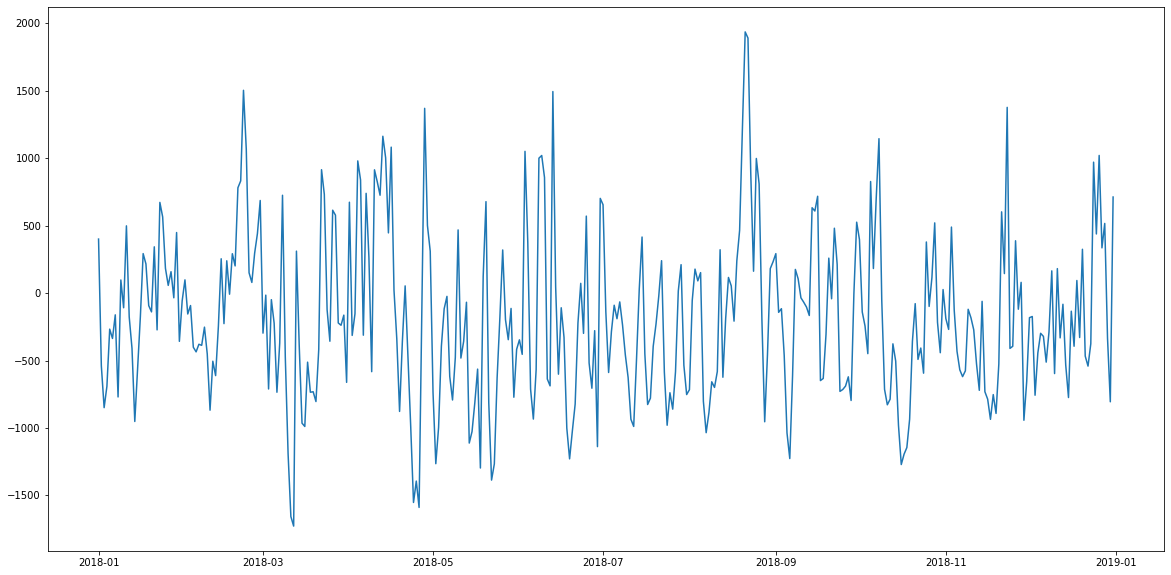

In [34]:
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(residuals.index, residuals)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



Text(0.5, 1.0, 'Residuals distribution (test set)')

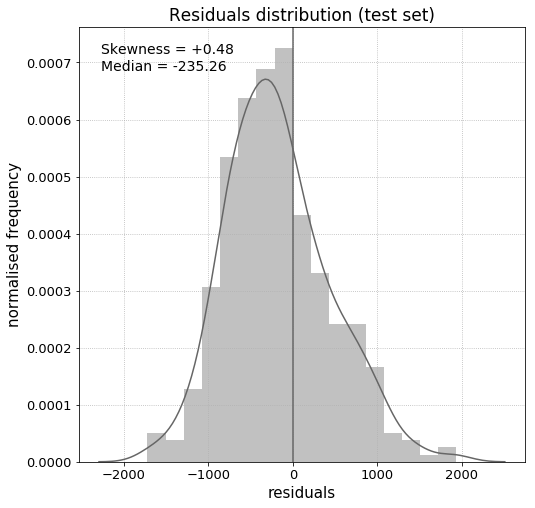

In [34]:

f, ax = plt.subplots(figsize=(8,8))
sns.distplot(residuals, ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.text(0.05, 0.9, "Skewness = {:+4.2f}\nMedian = {:+4.2f}".\
        format(skew(residuals), (residuals).median()), \
        fontsize=14, transform=ax.transAxes)

ax.axvline(0, color='0.4')

ax.set_title('Residuals distribution (test set)', fontsize=17)

# Add Weather regressor



In [35]:
m_reg = Prophet(mcmc_samples=300, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)
m_reg.add_country_holidays(country_name='US')
m_reg.add_regressor('TAVG', prior_scale=0.5, mode='multiplicative')
m_reg.add_regressor('PRCP', prior_scale=0.5, mode='multiplicative')
m_reg.add_regressor('SNOW', prior_scale=0.5, mode='multiplicative')
m_reg.add_regressor('AWND', prior_scale=0.5, mode='multiplicative')



In [36]:
data_train = daily.loc[:str(2018-1),:]
data_test = daily.loc[str(2018),:]
data_train.reset_index(inplace=True)
data_test.reset_index(inplace=True)
    
data_train = data_train.rename({'Date':'ds', 'Total':'y'}, axis=1)
data_test = data_test.rename({'Date':'ds', 'Total':'y'}, axis=1)

data_train.head()

,ds,y,PRCP,SNOW,SNWD,AWND,TAVG
0,2012-10-03,3521.0,0.0,0.0,0.0,16.33,56.0
1,2012-10-04,3475.0,0.0,0.0,0.0,14.54,56.5
2,2012-10-05,3148.0,0.0,0.0,0.0,12.75,59.5
3,2012-10-06,2006.0,0.0,0.0,0.0,11.41,60.5
4,2012-10-07,2142.0,0.0,0.0,0.0,2.91,60.5


In [37]:
m_reg.fit(data_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [38]:
future_reg = m_reg.make_future_dataframe(periods=len(data_test), freq='1D')
future_reg.head()

,ds
0,2012-10-03
1,2012-10-04
2,2012-10-05
3,2012-10-06
4,2012-10-07


In [39]:
future_reg = future_reg.merge(daily[['PRCP', 'SNOW', 'TAVG', 'AWND']], left_on='ds', right_on='Date')

In [40]:
future_reg.tail()

,ds,PRCP,SNOW,TAVG,AWND
2276,2018-12-27,0.01,0.0,43.0,3.13
2277,2018-12-28,0.43,0.0,44.0,10.29
2278,2018-12-29,0.63,0.0,47.0,15.21
2279,2018-12-30,0.00,0.0,43.5,6.71
2280,2018-12-31,0.00,0.0,38.5,4.92


In [41]:
len(future_reg), len(daily)

(2281, 2401)

In [42]:
# here is the forecast
forecast_reg = m_reg.predict(future_reg)

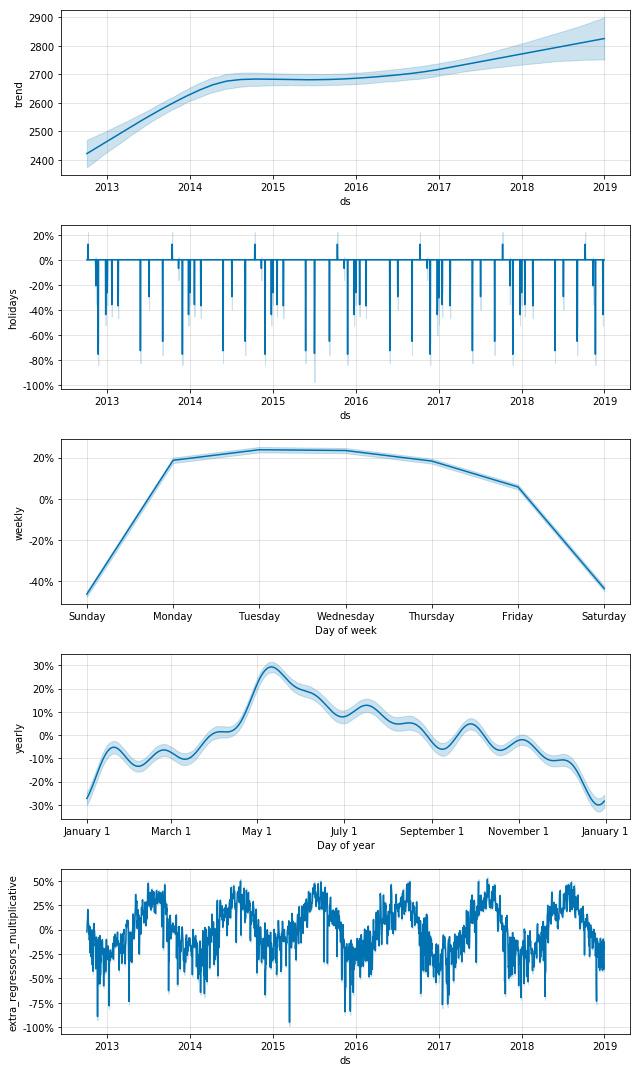

In [43]:
f = m_reg.plot_components(forecast_reg)

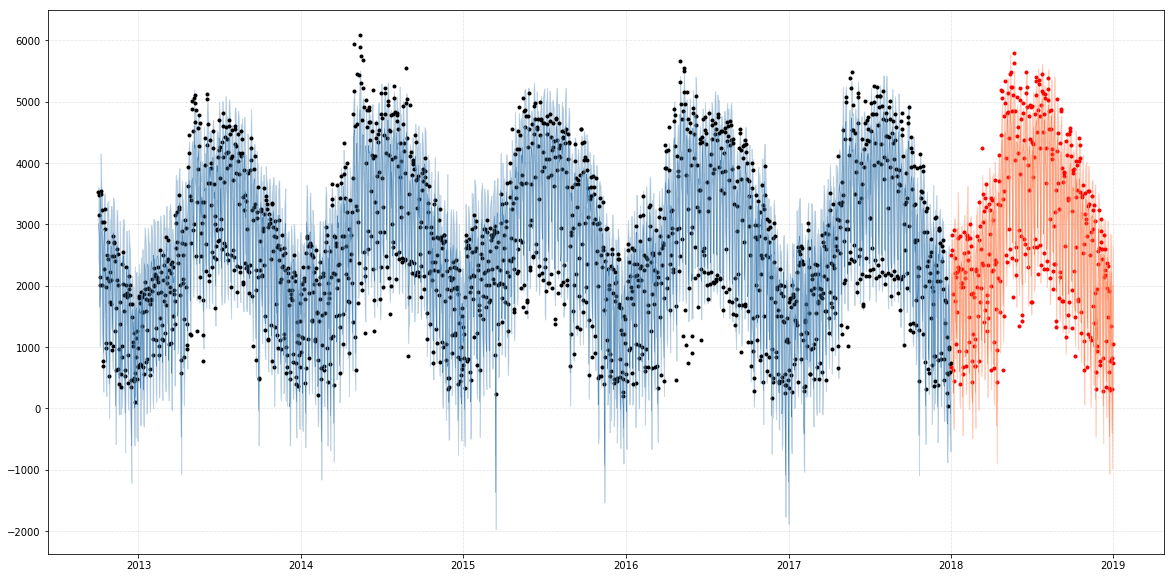

In [44]:
verif_reg = make_verif(forecast_reg, data_train, data_test)
f = plot_verif(verif_reg, year=2018);

In [45]:
MAE(verif_reg.loc['2018':,'y'].values, verif_reg.loc['2018':,'yhat'].values)

409.51649738626685

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



Text(0.5, 1.0, 'Residuals distribution (test set)')

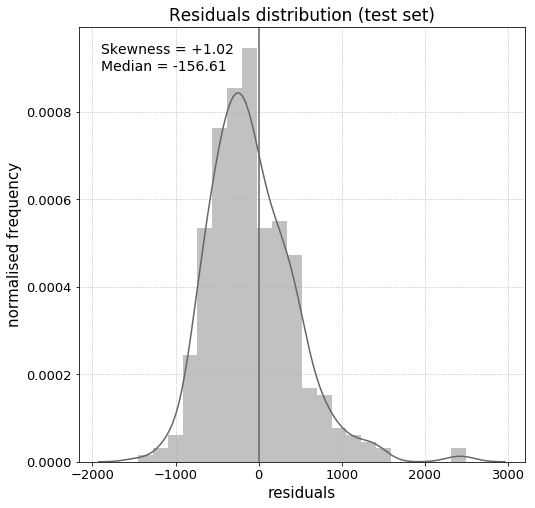

In [46]:
residuals_reg = (verif_reg.loc['2018':,'yhat'] - verif_reg.loc['2018':,'y'])
f, ax = plt.subplots(figsize=(8,8))
sns.distplot(residuals_reg, ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.text(0.05, 0.9, "Skewness = {:+4.2f}\nMedian = {:+4.2f}".\
        format(skew(residuals_reg), (residuals_reg).median()), \
        fontsize=14, transform=ax.transAxes)

ax.axvline(0, color='0.4')

ax.set_title('Residuals distribution (test set)', fontsize=17)

In [47]:
np.mean(residuals_reg), np.median(residuals_reg)

(-80.20373257926757, -156.6079261873465)

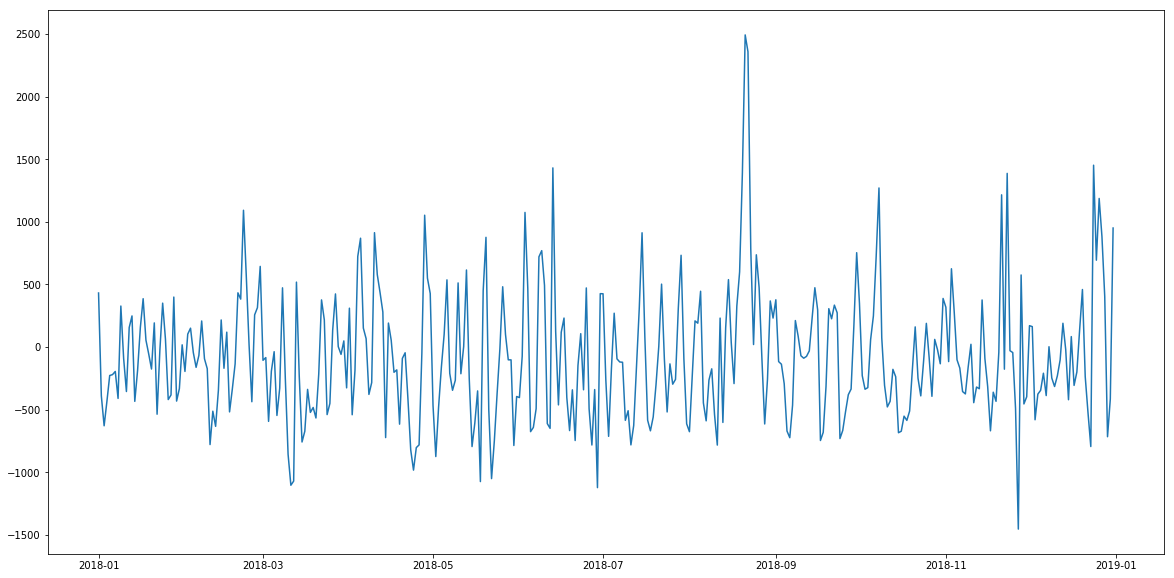

In [48]:
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(residuals_reg.index, residuals_reg)